## Data Challenge 1

### Mei Tessum

In this data challenge, the dependent variable is a binary variable that contains data coded as 2 (benign) and 4 (malignant), therefore, I am going to build a predictive model using logistic regression. This logistic regression model will predict P(Y=4) (or the probability of having the biopsied breast cell as malignant) as a function of Xs.

First,I will make some assuptions:
The independent variables should be independent of each other.
The sample size is big enough.

In [28]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [29]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
              names=["id_number","clump_thickness","cell_size_uniformity","cell_shape_uniformity",
                    "marginal_adhesion","single_epithelial_cell_size","bare_nuclei","bland_chromatin"
                    "normal_nucleoli","mitoses","class"])

In [30]:
df= df[df.single_epithelial_cell_size != "?"]
df=df.astype('int64')
df.dtypes

id_number                         int64
clump_thickness                   int64
cell_size_uniformity              int64
cell_shape_uniformity             int64
marginal_adhesion                 int64
single_epithelial_cell_size       int64
bare_nuclei                       int64
bland_chromatinnormal_nucleoli    int64
mitoses                           int64
class                             int64
dtype: object

In [31]:
df["class"][df['class']==2] = 0
df["class"][df['class']==4] = 1

In [32]:
df["class"].value_counts()

0    444
1    239
Name: class, dtype: int64

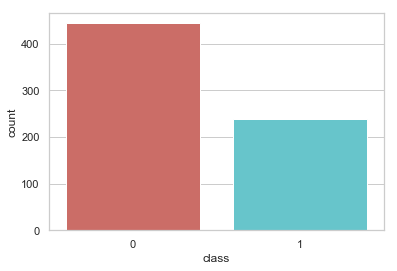

In [33]:
sns.countplot(x="class", data=df,palette="hls")
plt.show()
plt.savefig("count_plot")

In [34]:
count_benign = len(df[df['class']==0])
count_malignant = len(df[df['class']==1])
pct_of_malignant = count_malignant/(count_malignant+count_benign)
print("The percentage of malignant breat call is", pct_of_malignant*100)
pct_of_benign = count_benign/(count_malignant+count_benign)
print("The percentage of benign breat call is", pct_of_benign*100)

The percentage of malignant breat call is 34.99267935578331
The percentage of benign breat call is 65.00732064421669


Balanced dependent variable is improtant for logistic regression, and the ratio of malignant to benign breat call is 35:65, which indicates me to balance the class after doing data exploration.

In [36]:
df.groupby("class").mean()

,id_number,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatinnormal_nucleoli,mitoses
class,,,,,,,,,
0,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315
1,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510


Although have no idea what those independant variables mean, it seems high levels of independant variables tend to associate with malignant breast cell and low levels of independant variables tend to associate with benign breast cell. I notice here, the level of mitoses doesn't shown as large as of a difference in malignant and benign breast cell, but sitll follows the same pattern, and I will evaluate each feature's performance later. 

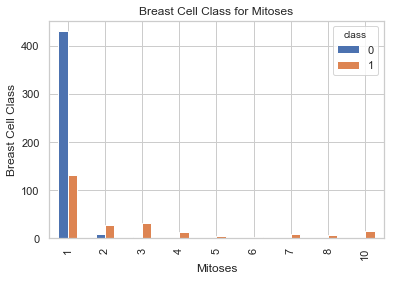

In [37]:
%matplotlib inline
pd.crosstab(df.mitoses,df["class"]).plot(kind='bar')
plt.title('Breast Cell Class for Mitoses')
plt.xlabel('Mitoses')
plt.ylabel('Breast Cell Class')
plt.savefig('Cell_Class_for_Mitoses')

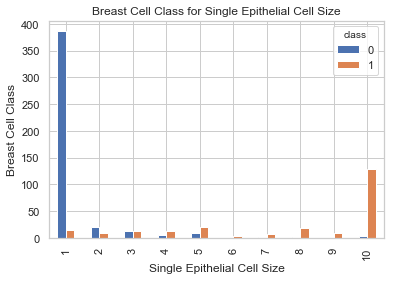

In [38]:
%matplotlib inline
pd.crosstab(df.single_epithelial_cell_size,df["class"]).plot(kind='bar')
plt.title('Breast Cell Class for Single Epithelial Cell Size')
plt.xlabel('Single Epithelial Cell Size')
plt.ylabel('Breast Cell Class')
plt.savefig('Cell_Class_for_single_epithelial_cell_size')

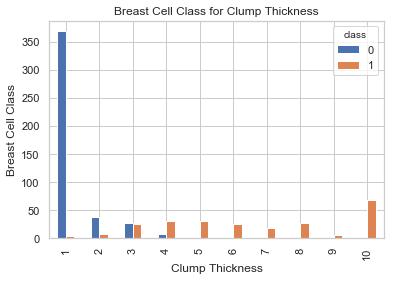

In [39]:
%matplotlib inline
pd.crosstab(df.clump_thickness,df["class"]).plot(kind='bar')
plt.title('Breast Cell Class for Clump Thickness')
plt.xlabel('Clump Thickness')
plt.ylabel('Breast Cell Class')
plt.savefig('Cell_Class_for_Clump_Thickness')

Now I will up-sample the malignant breast cancer cases using the SMOTE (Synthetic Minority Oversampling Technique) algorithm. This algorithm generates synthetic samples by randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

I will over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [40]:
X = df.loc[:, df.columns != 'class']
y = df.loc[:, df.columns == 'class']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['class'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of benign breast cancer in oversampled data",len(os_data_y[os_data_y['class']==0]))
print("Number of malignant breast cancer",len(os_data_y[os_data_y['class']==1]))
print("Proportion of benign breast cancer data in oversampled data is ",len(os_data_y[os_data_y['class']==0])/len(os_data_X))
print("Proportion of malignant breast cancer data in oversampled data is ",len(os_data_y[os_data_y['class']==1])/len(os_data_X))

length of oversampled data is  714
Number of benign breast cancer in oversampled data 357
Number of malignant breast cancer 357
Proportion of benign breast cancer data in oversampled data is  0.5
Proportion of malignant breast cancer data in oversampled data is  0.5


Recursive Feature Elimination

In [41]:
df_vars=df.columns.values.tolist()
y=['class']
X=[i for i in df_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


All the features seem play important roles, and therefore I will select them all.

Implementing the model

In [42]:
cols=["clump_thickness","cell_size_uniformity","cell_shape_uniformity",
                    "marginal_adhesion","single_epithelial_cell_size","bare_nuclei","bland_chromatin"
                    "normal_nucleoli","mitoses"]
X=os_data_X[cols]
y=os_data_y['class']
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.354590
         Iterations 8
                                Results: Logit
Model:                  Logit                Pseudo R-squared:     0.488      
Dependent Variable:     class                AIC:                  522.3552   
Date:                   2019-02-13 22:03     BIC:                  558.9222   
No. Observations:       714                  Log-Likelihood:       -253.18    
Df Model:               7                    LL-Null:              -494.91    
Df Residuals:           706                  LLR p-value:          2.8804e-100
Converged:              1.0000               Scale:                1.0000     
No. Iterations:         8.0000                                                
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------

The p-values for most of the variables are smaller than 0.05, except two variables (cell_size_uniformity and cell_shape_uniformity), therefore, I will remove them.

In [45]:
cols=["clump_thickness","marginal_adhesion","single_epithelial_cell_size","bare_nuclei","bland_chromatin"
                    "normal_nucleoli","mitoses"]
X=os_data_X[cols]
y=os_data_y['class']
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.356727
         Iterations 8
                                Results: Logit
Model:                  Logit                Pseudo R-squared:     0.485      
Dependent Variable:     class                AIC:                  521.4060   
Date:                   2019-02-13 22:06     BIC:                  548.8313   
No. Observations:       714                  Log-Likelihood:       -254.70    
Df Model:               5                    LL-Null:              -494.91    
Df Residuals:           708                  LLR p-value:          1.3509e-101
Converged:              1.0000               Scale:                1.0000     
No. Iterations:         8.0000                                                
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------

After I rerun the model the p-values for most of the variables are smaller than 0.05, and therefore this is our final model using to predict the class of breast cell.  

Logistic Regression Model Fitting

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predicting the test set results and calculating the accuracy

In [47]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


### Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[67  1]
 [ 5 70]]


The result is telling us that we have 67+70 correct predictions and 5+1 incorrect predictions.

Compute precision, recall, F-measure and support

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.99      0.96        68
          1       0.99      0.93      0.96        75

avg / total       0.96      0.96      0.96       143



Interpretation: 

### ROC Curve

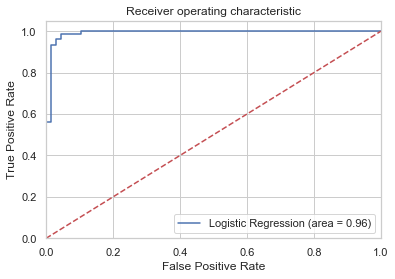

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()